<Center><font size = 16> <b>Grapevine - Technical Assessment</b></font></Center>

 <Center><font size = 5 > - Written by Rajat Mehta</font></Center> 

<font size = 6 ><b> Part One - Data Analysis</b></font> 

<font size = 3 >
The part one of the assessment deals with analysing the flight data and hotels data as provided by Grapevine.The analysis part divides into 3 key phases : <br>
    <b>- Flight Booking Analysis</b> - In this section , I will be reading the Flights Data and will be doing an exploratory data analysis on it. I am also going to define the whole one-way trip as booked by the customer and summarize the findings.<br>
    <b>- Hotels Booking Analysis</b> - The section deals with analyzing the data for Hotel Bookings.I will be also using an external airports data to gather the arrival & departure airport's longitude and latitude and use them in the analysis. <br>
    <b>- Customer's Trip Analysis</b> - This section encapsulates the trip of the customer by joining the flights data and the hotels data and tries to answer the question for how many flight bookings does customer also booked a hotel.
</font>

<font size= 4> <b>Flight Booking Analysis</b> </font>

<font size= 4>i) Data Cleaning & Manipulation </font>

<font size =3>
After reading the flights data , the data was required to be cleaned to generate relevant insights. Below are the steps taken to clean and manipulate the flights data for usage:

1) The departs & arrives attributes are converted to date format<br>
    
2) Developed the logic to identify different trips of the customer by joining the connecting flights taken by the customer. Getting the intended trip of the customer is essential and can provide huge amount of information on where customer may require to book a hotel or use other services
    
3) The logic is developed by using the time between two consecutive flights taken by the customer and the destination & origin of consecutive flights.If the time taken between 2 flights is less than 10 hours and the destination and origin of consecutive flights is same then the flight belongs to same trip.
    
4) Based on the above logic, the intended origin, destination, start time, end time of the trip & trip number for the customer are calculated.
    
5) Flight carriers are also calculated using the first 2 characters of flight number.
</font>
    

In [192]:
import pandas as pd
import warnings
from datetime import datetime, timedelta
import numpy as np

flights = pd.read_csv("Flights Data.csv")

flights["departs"] = pd.to_datetime(flights["departs"])
flights["arrives"] = pd.to_datetime(flights["arrives"])

flights["last_flight_arrival"] = flights.sort_values(['Company ID', 'Traveller ID', 'departs']).groupby(['Company ID', 'Traveller ID'])['arrives'].shift(1)
flights["last_flight_destination"] = flights.sort_values(['Company ID', 'Traveller ID', 'departs']).groupby(['Company ID', 'Traveller ID'])['destination'].shift(1)
flights["time_between_last_flight"] = (pd.to_datetime(flights['departs']) - pd.to_datetime(flights["last_flight_arrival"])).astype('timedelta64[m]')
flights["prev_flight_connecting"] = np.where((flights["time_between_last_flight"] <=600) & (flights["origin"] == flights["last_flight_destination"] ),1,0)
flights["trip_number"] = flights.sort_values(['Company ID', 'Traveller ID', 'departs']).groupby(['Company ID', 'Traveller ID','prev_flight_connecting']).cumcount() + 1
flights["trip_number"] = np.where(flights["prev_flight_connecting"] == 1,None,flights["trip_number"])
flights["trip_number"] = flights.sort_values(['Company ID', 'Traveller ID', 'departs'])["trip_number"].ffill()
flights["coupon_number"] = flights.sort_values(['Company ID', 'Traveller ID', 'trip_number']).groupby(['Company ID', 'Traveller ID','trip_number']).cumcount() + 1
flights["intended_trip_origin"] = np.where(flights["coupon_number"] == 1,flights["origin"],None)
flights["intended_trip_origin"] = flights.sort_values(['Company ID', 'Traveller ID', 'trip_number'])["intended_trip_origin"].ffill()
flights["intended_trip_start_time"] = np.where(flights["coupon_number"] == 1,flights["departs"],None)
flights["intended_trip_start_time"] = flights.sort_values(['Company ID', 'Traveller ID', 'trip_number'])["intended_trip_start_time"].ffill()
flights["intended_trip_start_time"] = pd.to_datetime(flights["intended_trip_start_time"])


flights["next_trip_number"] = flights.sort_values(['Company ID', 'Traveller ID']).groupby(['Company ID', 'Traveller ID'])['trip_number'].shift(-1)
flights["intended_trip_destination"] = np.where(flights["trip_number"] != flights["next_trip_number"],flights["destination"],None)
flights["intended_trip_destination"] = flights.sort_values(['Company ID', 'Traveller ID', 'trip_number'])["intended_trip_destination"].bfill()
flights["intended_trip_end_time"] = np.where(flights["trip_number"] != flights["next_trip_number"],flights["arrives"],None)
flights["intended_trip_end_time"] = flights.sort_values(['Company ID', 'Traveller ID', 'trip_number'])["intended_trip_end_time"].bfill()
flights["intended_trip_end_time"] = pd.to_datetime(flights["intended_trip_end_time"])
flights["carrier"] = flights["flight"].str[:2]
flights["carrier"] = flights["carrier"].replace(["6."],"6E")
flights = flights[['Company ID','Traveller ID', 'departs', 'origin','destination', 'flight', 'trip_number', 'intended_trip_origin', 'intended_trip_start_time', 'intended_trip_destination','intended_trip_end_time','carrier']]


<font size= 4> ii) Insights </font>

<font size=3> The summary statistics suggests that the data consists information related to 12,093 business customers coming from 530 unique companies. The total flights taken by all these customers are 60,131 and based on the trip logic developed these customers have taken 49,130 trips. Average business trips taken by company professionals are 92.7.</font>

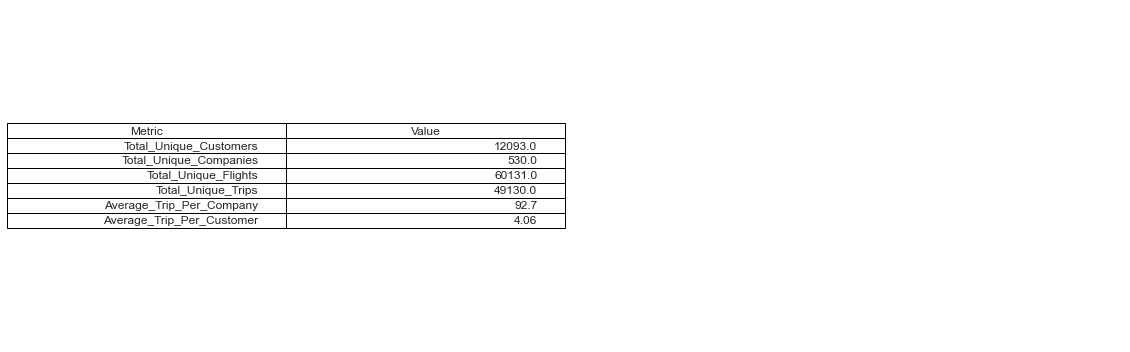

In [393]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Total_Unique_Customers = flights["Traveller ID"].nunique()
Total_Unique_Companies = flights["Company ID"].nunique()
Total_Unique_Flights = flights["Company ID"].count()
Total_Unique_Trips = flights.groupby(["Company ID","Traveller ID","trip_number"]).size().reset_index()["Company ID"].size
Average_Trip_Per_Company = round((Total_Unique_Trips/Total_Unique_Companies),2)
Average_Trip_Per_Customer = round((Total_Unique_Trips/Total_Unique_Customers),2)

a = {"Total_Unique_Customers":Total_Unique_Customers,"Total_Unique_Companies":Total_Unique_Companies,"Total_Unique_Flights":Total_Unique_Flights,
     "Total_Unique_Trips": Total_Unique_Trips,"Average_Trip_Per_Company":Average_Trip_Per_Company,"Average_Trip_Per_Customer" : Average_Trip_Per_Customer}

summary_data = pd.DataFrame(a.items(), columns=['Metric', 'Value'])


fig, ax = plt.subplots(figsize=(10,5))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

tbl = ax.table(cellText=summary_data.values, colLabels=summary_data.columns, loc='left')

fig.tight_layout()
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)

plt.show()

<font size =3>The top 5 carriers that customers like to travel are : British Airways, Lufthansa, FlyBe(Connect Airways), KLM Dutch Airways & EasyJet </font> 

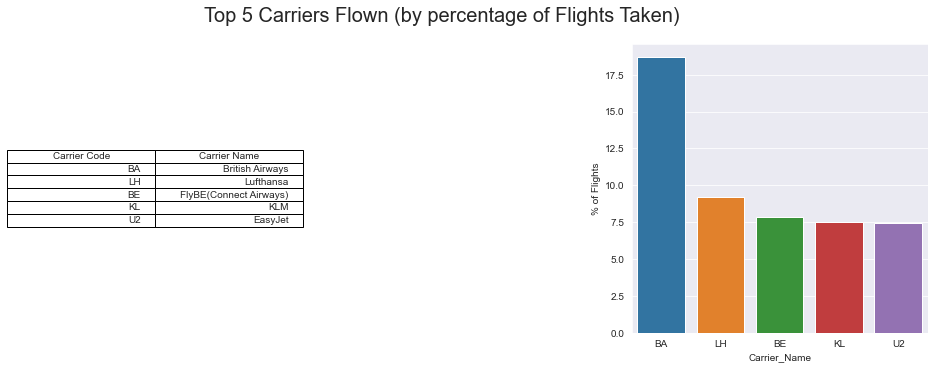

In [296]:

Top_5_Carrier = pd.DataFrame()
Top_5_Carrier["Count_of_Flights"] = flights['carrier'].value_counts()
Top_5_Carrier["% of Flights"] = round((flights['carrier'].value_counts()/flights['carrier'].size) * 100,2)
Top_5_Carrier = Top_5_Carrier.reset_index()
Top_5_Carrier.columns = ["Carrier_Name","Count_Of_Flights","% of Flights"] 
Top_5_Carrier = Top_5_Carrier[:5]

carrier_name_dict = {"BA":"British Airways","LH":"Lufthansa","BE":"FlyBE(Connect Airways)","KL":"KLM","U2":"EasyJet"}
carrier_name = pd.DataFrame(carrier_name_dict.items(), columns=['Carrier Code', 'Carrier Name'])


fig, (ax, ax2) = plt.subplots(1,2,figsize=(14,5))

fig.suptitle('Top 5 Carriers Flown (by percentage of Flights Taken)', fontsize = 20)

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=carrier_name.values, colLabels=carrier_name.columns, loc='left')

fig.tight_layout()


sns.set_style('darkgrid')

ax2 = sns.barplot(Top_5_Carrier["Carrier_Name"],Top_5_Carrier["% of Flights"] )
plt.show()






<font size =3>The top 5 trip destination that customers wanted to travel are : London(Heathrow Airport), Birmingham, Manchester, Edinburgh & Amsterdam </font> 

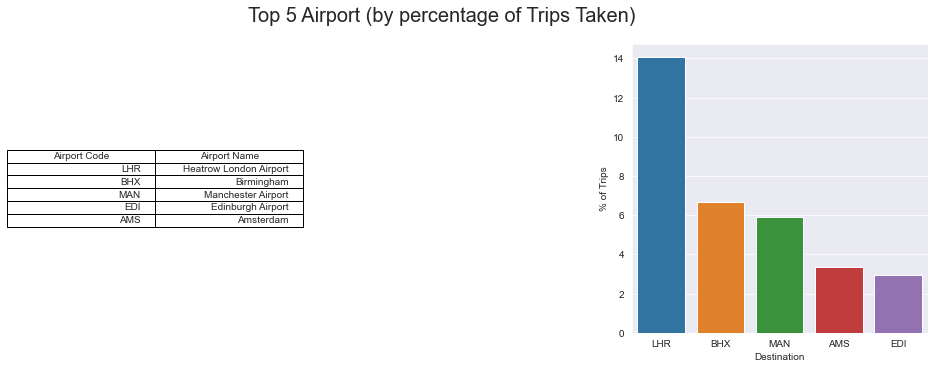

In [299]:
flights_join = flights[['Company ID','Traveller ID', 'trip_number', 'intended_trip_origin', 'intended_trip_start_time', 'intended_trip_destination','intended_trip_end_time']].drop_duplicates()
Top_5_Dest = pd.DataFrame()
Top_5_Dest["Count_of_Trips"] = flights_join['intended_trip_destination'].value_counts()
Top_5_Dest["% of Trips"] = round((flights_join['intended_trip_destination'].value_counts()/flights_join['intended_trip_destination'].size) * 100,2)
Top_5_Dest = Top_5_Dest.reset_index()
Top_5_Dest.columns = ["Destination","Count_Of_Trips","% of Trips"] 
Top_5_Dest = Top_5_Dest[:5]


dest_name_dict = {"LHR":"Heatrow London Airport","BHX":"Birmingham","MAN":"Manchester Airport","EDI":"Edinburgh Airport","AMS":"Amsterdam"}
dest_name = pd.DataFrame(dest_name_dict.items(), columns=['Airport Code', 'Airport Name'])


fig, (ax, ax2) = plt.subplots(1,2,figsize=(14,5))

fig.suptitle('Top 5 Airport (by percentage of Trips Taken)', fontsize = 20)

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=dest_name.values, colLabels=dest_name.columns, loc='left')

fig.tight_layout()


sns.set_style('darkgrid')

ax2 = sns.barplot(Top_5_Dest["Destination"],Top_5_Dest["% of Trips"] )
plt.show()



<font size= 4>iii) Opportunities </font>

<font size =3>
    1) Grapevine can potentially collaborate with the top travelling airlines to push their in-flight products using grapevine's platform.<br>
    2)  Grapevine can collaborate with the restaurants and store owners at the top travelled airports to push their products using grapevine's platform.<br>
    3)  Grapevine can use the trip identification logic to check whether customer had booked the return flight or not and notify the customer with recommended flights<br>

    
</font>

<font size= 4> **Hotel Booking Analysis** </font>

<font size= 4> i) Data Cleaning & Manipulation </font>

<font size = 3 >
The hotel booking data provided have been cleaned and formatted by performing following steps:<br>
    
  1) The Check-in date & check-out date attributes are converted to date format.
    
  2) With the hotels data, another external dataset airports is used. The airports dataset provides the co-ordinates of most of the  world's airports and is used to find the distance of the hotel from airport.
    

</font>

In [386]:
from math import sin, cos, sqrt, atan2, radians
hotels = pd.read_csv("Hotels Data.csv")
airports = pd.read_csv("airports.csv",encoding='cp1252')
hotels = hotels.merge(airports,how = "left",left_on = ["arrival_airport"] , right_on = ["airport_iata_code"])
hotels = hotels[['Company ID','traveller ID','arrival_airport','departure_airport','city_code','latitude_x','longitude_x','check_in_date','check_out_date','HotelName','airport_name','airport_country','latitude_y','longitude_y']]
hotels['check_in_date'] = pd.to_datetime(hotels['check_in_date'])
hotels['check_out_date'] = pd.to_datetime(hotels['check_out_date'])

def coord_dist(coord_1,coord_2):
    if (coord_1 is not None) and (coord_2 is not None):
        # approximate radius of earth in km
        R = 6373.0
        dlon = radians(coord_2[1]) - radians(coord_1[1])
        dlat = radians(coord_2[0]) - radians(coord_1[0])

        a = sin(dlat / 2)**2 + cos(radians(coord_1[0])) * cos(radians(coord_2[0])) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        return distance
    return None


hotels['distance_in_miles'] = hotels.apply(lambda row:coord_dist((row['latitude_x'],row['longitude_x']), (row['latitude_y'],row['longitude_y'])) * 0.621371,axis = 1)



<font size= 4>ii) Insights </font>

<font size =3> The total unique customers that booked the hotel are 12,484 and on an average the customers lived 12.51 miles away from the airport.

Note: There exist bookings in the hotel dataset for which airport was not present or the co-ordinates in the airports file were missing.Those bookings are not considered while calculating average distance. 

</font>

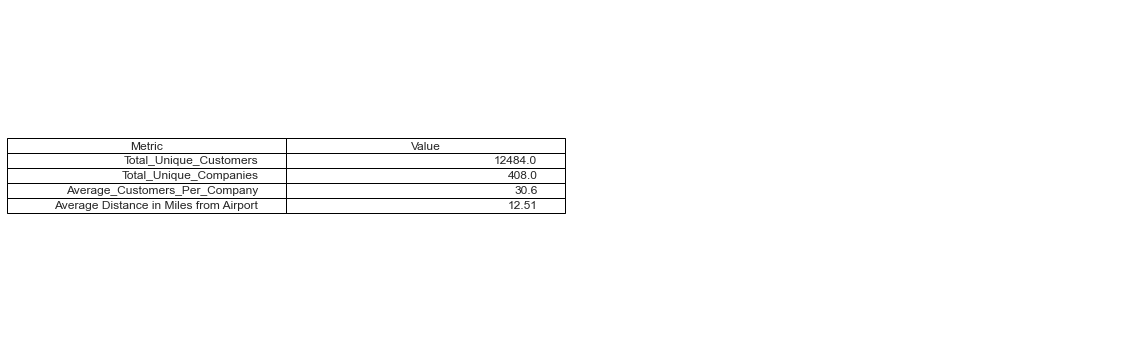

In [374]:
Total_Unique_Customers = hotels["traveller ID"].nunique()
Total_Unique_Companies = hotels["Company ID"].nunique()
Average_Customers_Per_Company = round((Total_Unique_Customers/Total_Unique_Companies),2)
Average_Distance_in_Miles = round(hotels[hotels["distance_in_miles"] < 100]["distance_in_miles"].mean(),2)

a = {"Total_Unique_Customers":Total_Unique_Customers,"Total_Unique_Companies":Total_Unique_Companies,
     "Average_Customers_Per_Company":Average_Customers_Per_Company,
     "Average Distance in Miles from Airport": Average_Distance_in_Miles}

summary_data = pd.DataFrame(a.items(), columns=['Metric', 'Value'])

#summary_data

fig, ax = plt.subplots(figsize=(10,5))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

tbl = ax.table(cellText=summary_data.values, colLabels=summary_data.columns, loc='left')

fig.tight_layout()
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)

plt.show()


<font size =3>The top 5 most booked hotels by customers are : Park Plaza, Jurys Inn, Citizenm London, Village Manchester & Doubletree by Hilton </font>

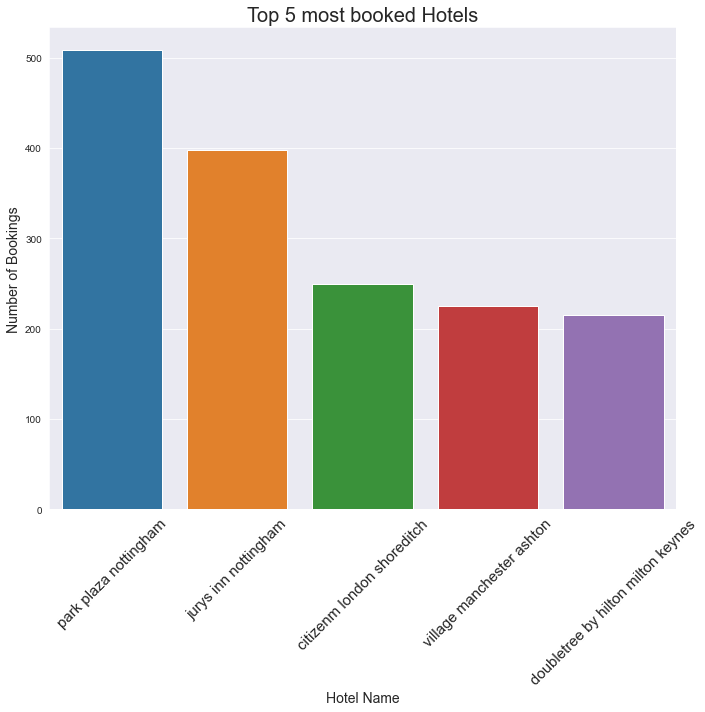

In [375]:
Top_5_Hotels = pd.DataFrame()
Top_5_Hotels["Count_of_Bookings"] = hotels['HotelName'].value_counts()
Top_5_Hotels = Top_5_Hotels.reset_index()
Top_5_Hotels.columns = ["Hotel_Name","Count_Of_Bookings"] 
Top_5_Hotels = Top_5_Hotels[:5]

plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

ax2 = sns.barplot(Top_5_Hotels["Hotel_Name"],Top_5_Hotels["Count_Of_Bookings"] )
ax2.set_title("Top 5 most booked Hotels", fontsize = 20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize = 15)
ax2.set_xlabel("Hotel Name",fontsize=14)
ax2.set_ylabel("Number of Bookings",fontsize=14)

plt.show()


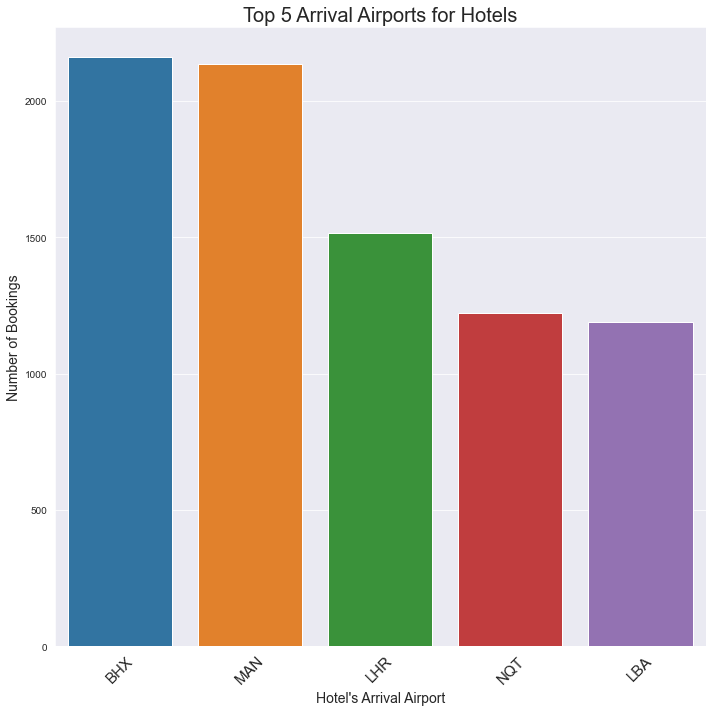

In [398]:
Top_5_Hotels = pd.DataFrame()
Top_5_Hotels["Count_of_Bookings"] = hotels['arrival_airport'].value_counts()
Top_5_Hotels = Top_5_Hotels.reset_index()
Top_5_Hotels.columns = ["Hotel_Arrival_Airport","Count_Of_Bookings"] 
Top_5_Hotels = Top_5_Hotels[:5]

plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

ax2 = sns.barplot(Top_5_Hotels["Hotel_Arrival_Airport"],Top_5_Hotels["Count_Of_Bookings"] )
ax2.set_title("Top 5 Arrival Airports for Hotels", fontsize = 20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize = 15)
ax2.set_xlabel("Hotel's Arrival Airport",fontsize=14)
ax2.set_ylabel("Number of Bookings",fontsize=14)

plt.show()

<font size= 4>iii) Opportunities </font>

<font size =3>
 1)  Grapevine can potentially maps the hotel name with the associated hotel chain. The hotel chain information can be used for future recommendations to the customer<br>
 2)  Grapevine can use the distance from airport information to stregthen their recommendation to the customers.<br>
 3)  Grapevine can use the distance from airport to sell the taxi services to the customers.<br>
    
</font>

<font size= 4> **Customer's Trip Analysis** </font>

<font size = 3 >
In this part of analysis,I tried to associate the hotel bookings information with the customer's trip. The information is identified by building up a logic in which if the customer have checked-in to the hotel within 2 days(on the day of trip end or next day) after his/her trip ends, then that hotel is said to be identified with that flight trip.

</font>

In [387]:
import pandasql as ps
flights_join = flights[['Company ID','Traveller ID', 'trip_number', 'intended_trip_origin', 'intended_trip_start_time', 'intended_trip_destination','intended_trip_end_time']].drop_duplicates()
flights_join = flights_join.rename({'Company ID': 'company_id', 'Traveller ID': 'traveller_id'}, axis=1)
hotels = hotels.rename({'Company ID': 'company_id', 'traveller ID': 'traveller_id'}, axis=1)
flights_join['intended_trip_end_date'] = flights_join['intended_trip_end_time'].dt.date
hotels['check_in_date'] = hotels['check_in_date'].dt.date


sqlcode = '''
select flights_join.*,hotels.*,julianday(hotels.check_in_date)  - julianday(flights_join.intended_trip_end_date) as diff,
case when hotels.traveller_id is null then "Hotel_Not_Booked" else "Hotel_Booked" end as is_hotel_booked
from flights_join
left join hotels 
on flights_join.company_id = hotels.company_id and flights_join.traveller_id = hotels.traveller_id 
and julianday(hotels.check_in_date)  - julianday(flights_join.intended_trip_end_date) <= 2
and julianday(hotels.check_in_date)  - julianday(flights_join.intended_trip_end_date) >= 0
'''

newdf = ps.sqldf(sqlcode,locals())


<font size =3> Based on the above logic, it was found that only 20.3% of the trips are associated with any flight trips. Other 80% of the trips are either single day return trip or do not have any associated hotel booking. Grapevine can use this information to target the customers that do not book the hotel.</font>

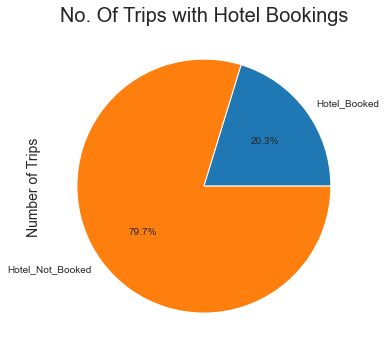

In [392]:
data = newdf.groupby("is_hotel_booked")["trip_number"].count()
plt.figure(figsize=(10,5))
ax = data.plot.pie(autopct="%.1f%%")
ax.set_ylabel("Number of Trips",fontsize=14)
ax.set_title("No. Of Trips with Hotel Bookings", fontsize = 20)
plt.show()

<font size=4>**Comments**</font>

<font size =3> 
 1) Grapevine should get more clean data from their partners in order to generate relevant opportunities. For Example - Flights data should have "Booking ID" information that can be used directly to identify customer's trip.<br>
 2) Grapevine should try to accomodate other rich data sources to generate better insights such as Hotel name to hotel chain mapping data, loyalty points data, customer's home area information etc.<br>
 3) Hotel data should also include the information on type of room booked ,room's ameneties and price to better understand customer's preferences. <br>
    
</font>

<font size = 6 ><b> Part Two - Problem Solving & Planning</b></font> 

<font size = 3> Our hotel recommendations engine currently generates a list of suitable hotels in a destination based on a number of factors including availability, pricing, star rating and distance from the location. It does not involve any element of personalisation to the traveler’s preferences or past behaviour. 
Our vision is to personalise the recommended hotels sent, as we believe that offering the most relevant hotels will increase our value to customers and our booking conversion rates. If you were asked to work on this: <br>
    
 ● What data would you want access to? <br>
 ● What investigatory techniques would you use? <br>
 ● What outputs would you expect to create? <br>
 ● How would you measure success? What metrics would you be interested in, and how might you present them to stakeholders? <br></font>


<font size =4> <b>What data would you want access to?</b></font>

<font size = 3> To personalize the recommendation of hotels to the customers, the data required would be as follows:<br>
    
1. Customer's Hotel Booking Data - This data should contain information on hotels booked by customer in the past. The data should include hotel name, hotel city, hotel chain , distance from downtown area, price booked, star rating of the hotel at the time of booking, loyalty points used, platform where hotel booked, available hotels shown at the time of booking and type of room booked.<br>
    
2. Customer's platform search filter data - This data should contain the information of filters used on the booking platform to search the hotel. The data should include area searched, flag if the dates used include weekend in search query, distance of searched area from downtown, distance of searched area from nearest airport, number of rooms searched, number of adults.<br>
    
3. Customer's hotel review/rating data - This data should contain the information of reviews and ratings given by users to the hotels. The data should include rating score and textual review for the hotel used by customer. 
</font>

<font size =4> <b>What investigatory techniques would you use?</b> </font>

<font size = 3> The investigatory techniques that I would use to build a better recommendation system are as follows :<br>

Exploratory Data Analysis<br>
1. Customer Segmentation - Create the segment of customers on the basis of available attributes. A customer may like to book nearer to airport or nearer to downtown area , price sensitive , prefers a particular hotel chain etc. A heuristic model can be created to recommend relevant hotels to customer based on their segmentation.<br>
2. Attribute selection - Find the key attributes that can be used to recommend the relevant hotels to the customers by performing a correlation analysis.<br>
3.Variable Transformation - The variable can be mathematically transformed to check if there transformations make better sense to be used for recommendations. For example the distance from airport can be transformed to low, medium & hugh bucket.<br>
4.Algorithm Techniques - Use the different algorithms to model the data in order to find the best algorithm that works best for the hotel recommendations
    
    


</font>

<font size =4> <b>What outputs would you expect to create?</b> </font>

<font size = 3> The output of the recommendation engine should be a dataset containing the score for each suitable hotel present on the destination for which customer has an intent to travel. These scores will be generated by using the above mentioned customer's data and calculating the similarity of available hotel choices for a destination with customer's previous choices.Based on the scores, Top 3 or Top 5 recommendations can be sent to the customer via E-Mails. The dataset for the scores will look something like this : 
    
![alt text](Recommendation.png "Title")
</font>

<font size = 4> <b>How would you measure success? What metrics would you be interested in, and how might you present them to stakeholders?</b> </font>

<font size =3>
1. The metric I would be interested in would be the hotel booking rate within Top 3 recommendation as per new model or the booking rate from the E-Mail sent using the new recommendation engine.<br> 
2. The success can be measured by comparing the personalised recommendation engine booking rate with that of the old hotel recommendation strategy . An A/B test can be set up where in Grapevine can send the recommendation to bunch of customers via E-Mail using old technique and send the recommendations using new algorithm to another set of customers. The booking rate within both set of customers can be compared to check if the new model gives significantly better results.<br>
3. A Tableau dashboard can be created to track the performance of A/B test and can be used to present to the stakeholders.  
</font>